# Technology focus: Visium HD (SpaceRanger 4.0)

This notebook demonstrates how to work with Visium HD data from **SpaceRanger 4.0**, which introduces cell and nucleus segmentation capabilities. Unlike the [binned Visium HD workflow](technology_visium_hd.ipynb), where data is represented as bins at multiple resolutions (2µm, 8µm, 16µm), this notebook focuses on analyzing **cell-level segmentations**. We will load nucleus and cell segmentations, perform quality control, clustering, and visualize gene expression at the single-cell level. The dataset used here is a Visium HD Mouse Brain (Fresh Frozen) processed with SpaceRanger 4.0.1.

In [17]:
import spatialdata as sd
import spatialdata_io as sdio
import matplotlib.pyplot as plt
import scanpy as sc
import spatialdata_plot  # noqa: F401

print(f"spatialdata_io=={sdio.__version__}")
print(f"spatialdata=={sd.__version__}")

spatialdata_io==0.5.1
spatialdata==0.6.2.dev1+g53b9438a3


# Download Visium HD example dataset from 10x public data repository

You'll need approximately 15 Gb of disk space. [The data can be downloaded from the 10x public data repository](https://www.10xgenomics.com/datasets/visium-hd-three-prime-mouse-brain-fresh-frozen).

Information regarding data licensing and attribution for the dataset listed above are also available at: https://github.com/scverse/spatialdata-notebooks/tree/main/datasets.

Simple convenience scripts for downloading the data and converting it to SpatialData Zarr are [available in `spatialdata-sandbox`](https://github.com/giovp/spatialdata-sandbox/tree/main/visium_hd_4.0.1_io).

## `spatialdata-io` supports Visium HD 4.0 data
Crucially, the script [`to_zarr.py`](https://github.com/giovp/spatialdata-sandbox/blob/main/visium_hd_4.0.1_io/to_zarr.py) uses `spatialdata-io` for reading the Visium HD SpaceRanger 4.0 data. Here we use the parameters:
- `load_segmentation_only=True`, to avoid loading the bins and only focus on cell segmentation;
- `load_nucleus_segmentation=True`, to derive the gene expression information by aggregating bins into nuclei geometries.
Please consult [the documentation for `visium_hd()`](https://spatialdata.scverse.org/projects/io/en/stable/generated/spatialdata_io.visium_hd.html) for all the possible configurations.

# Read in Visium HD data

After downloading the data and converting it to the SpatialData Zarr format, create symlinks so the subsequent command can access it.

In [18]:
visium_hd_mouse_brain = sd.read_zarr("visium_hd_4.0.1.zarr")

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_io/io_table.py:21: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  table = read_anndata_zarr(str(store))


In [19]:
visium_hd_mouse_brain

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/visium_hd_4.0.1_io/data.zarr
├── Images
│     ├── 'Visium_HD_3prime_Mouse_Brain_hires_image': DataArray[cyx] (3, 5492, 6000)
│     └── 'Visium_HD_3prime_Mouse_Brain_lowres_image': DataArray[cyx] (3, 549, 600)
├── Shapes
│     ├── 'Visium_HD_3prime_Mouse_Brain_cell_segmentations': GeoDataFrame shape: (84031, 2) (2D shapes)
│     └── 'Visium_HD_3prime_Mouse_Brain_nucleus_segmentations': GeoDataFrame shape: (83153, 2) (2D shapes)
└── Tables
      ├── 'cell_segmentations': AnnData (84031, 33696)
      └── 'nucleus_segmentations': AnnData (83153, 33696)
with coordinate systems:
    ▸ 'Visium_HD_3prime_Mouse_Brain', with elements:
        Visium_HD_3prime_Mouse_Brain_hires_image (Images), Visium_HD_3prime_Mouse_Brain_lowres_image (Images), Visium_HD_3prime_Mouse_Brain_cell_segmentations (Shapes), Visium_HD_3prime_Mouse_Brain_nucleus_segmentations (Shapes)
    ▸ 'Visium_HD_3prime_Mouse_Brain

# Visualize the images and segmentations


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


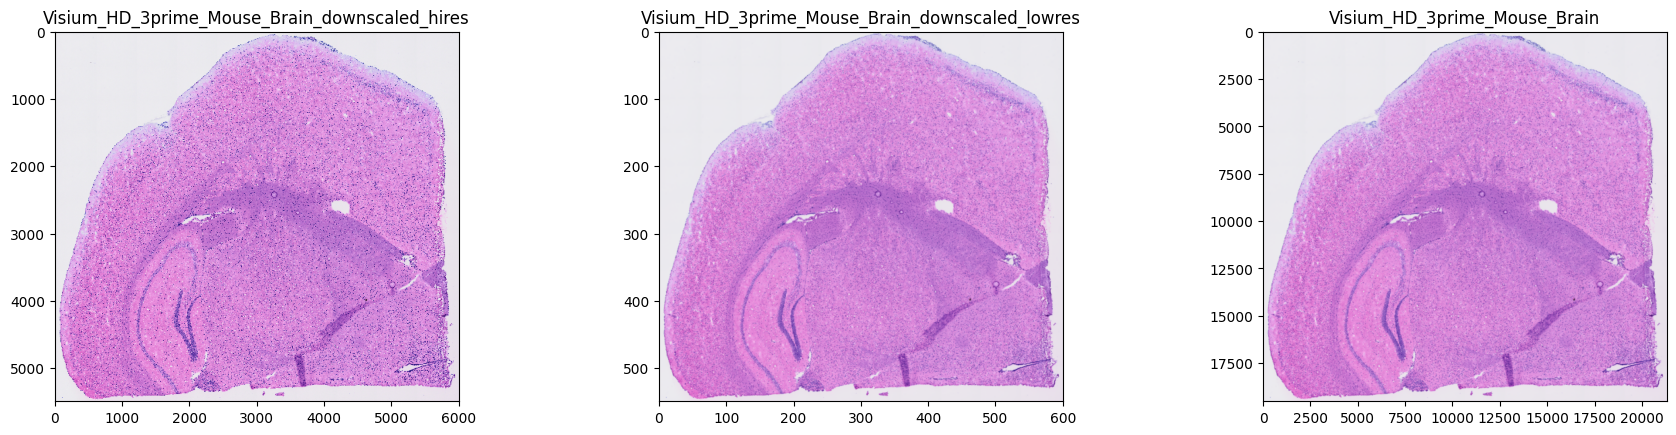

In [20]:
visium_hd_mouse_brain.pl.render_images().pl.show()

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


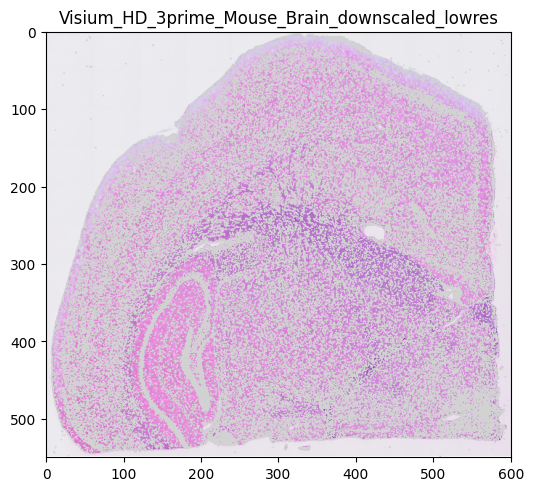

In [21]:
(
    visium_hd_mouse_brain.pl.render_images("Visium_HD_3prime_Mouse_Brain_lowres_image")
    .pl.render_shapes("Visium_HD_3prime_Mouse_Brain_cell_segmentations")
    .pl.show(coordinate_systems="Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
)

Now let's visualizes a relevant gene Hpca


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/query/relational_query.py:78: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  table = table[table.obs[region_key].isin(element_names)].copy()


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


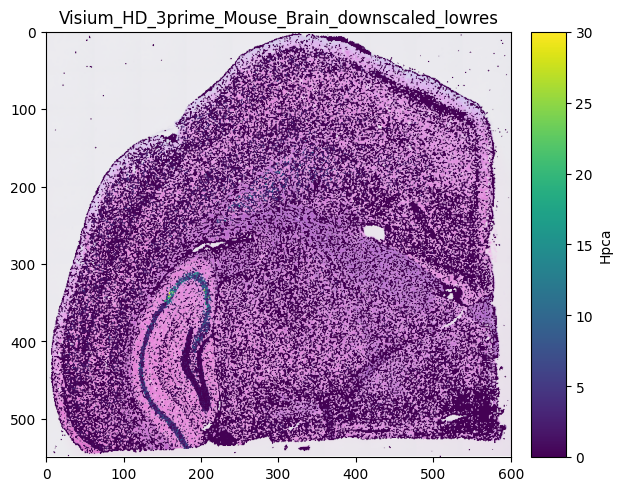

In [22]:
gene_name = "Hpca"
(
    visium_hd_mouse_brain.pl.render_images("Visium_HD_3prime_Mouse_Brain_lowres_image")
    .pl.render_shapes("Visium_HD_3prime_Mouse_Brain_cell_segmentations", color=gene_name)
    .pl.show(coordinate_systems="Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
)

# Quality control and filtering


In [23]:
visium_hd_mouse_brain

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/visium_hd_4.0.1_io/data.zarr
├── Images
│     ├── 'Visium_HD_3prime_Mouse_Brain_hires_image': DataArray[cyx] (3, 5492, 6000)
│     └── 'Visium_HD_3prime_Mouse_Brain_lowres_image': DataArray[cyx] (3, 549, 600)
├── Shapes
│     ├── 'Visium_HD_3prime_Mouse_Brain_cell_segmentations': GeoDataFrame shape: (84031, 2) (2D shapes)
│     └── 'Visium_HD_3prime_Mouse_Brain_nucleus_segmentations': GeoDataFrame shape: (83153, 2) (2D shapes)
└── Tables
      ├── 'cell_segmentations': AnnData (84031, 33696)
      └── 'nucleus_segmentations': AnnData (83153, 33696)
with coordinate systems:
    ▸ 'Visium_HD_3prime_Mouse_Brain', with elements:
        Visium_HD_3prime_Mouse_Brain_hires_image (Images), Visium_HD_3prime_Mouse_Brain_lowres_image (Images), Visium_HD_3prime_Mouse_Brain_cell_segmentations (Shapes), Visium_HD_3prime_Mouse_Brain_nucleus_segmentations (Shapes)
    ▸ 'Visium_HD_3prime_Mouse_Brain

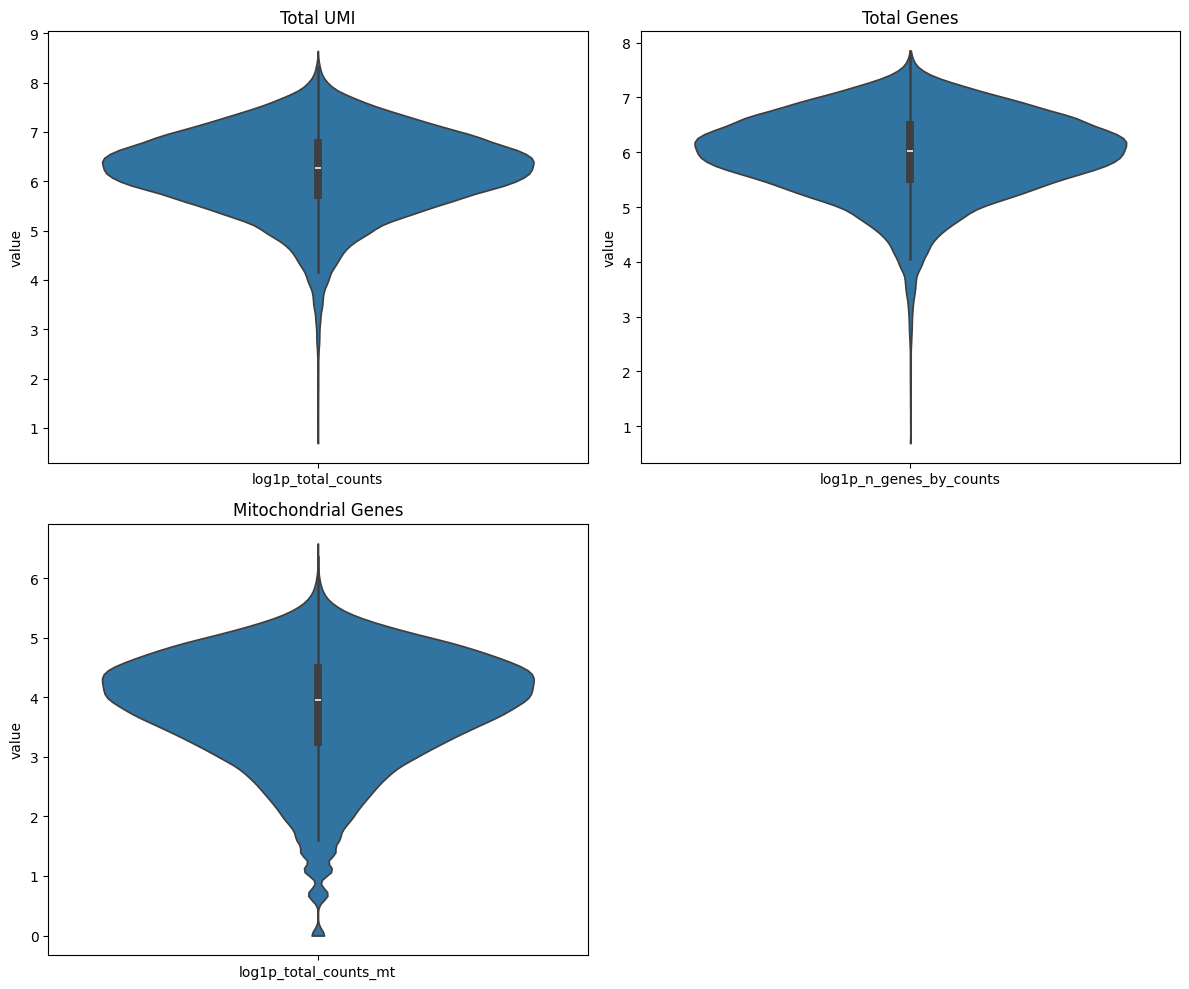

In [24]:
# Add mitochondrial gene calculation for QC
visium_hd_mouse_brain.tables["cell_segmentations"].var["mt"] = visium_hd_mouse_brain.tables[
    "cell_segmentations"
].var_names.str.startswith(("MT-", "mt-"))
sc.pp.calculate_qc_metrics(
    visium_hd_mouse_brain.tables["cell_segmentations"], qc_vars=["mt"], inplace=True, percent_top=None
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sc.pl.violin(
    adata=visium_hd_mouse_brain.tables["cell_segmentations"],
    keys=["log1p_total_counts"],
    stripplot=False,
    inner="box",
    ax=axes[0, 0],
    show=False,
)
axes[0, 0].set_title("Total UMI")

sc.pl.violin(
    adata=visium_hd_mouse_brain.tables["cell_segmentations"],
    keys=["log1p_n_genes_by_counts"],
    stripplot=False,
    inner="box",
    ax=axes[0, 1],
    show=False,
)
axes[0, 1].set_title("Total Genes")

sc.pl.violin(
    adata=visium_hd_mouse_brain.tables["cell_segmentations"],
    keys=["log1p_total_counts_mt"],
    stripplot=False,
    inner="box",
    ax=axes[1, 0],
    show=False,
)
axes[1, 0].set_title("Mitochondrial Genes")

# Hide the unused subplot
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()
plt.close("all")

# Normalization and Clustering


In [25]:
sc.pp.normalize_total(visium_hd_mouse_brain.tables["cell_segmentations"], target_sum=None)
sc.pp.log1p(visium_hd_mouse_brain.tables["cell_segmentations"])
sc.tl.pca(visium_hd_mouse_brain.tables["cell_segmentations"])

In [26]:
# neighborhood and clustering resolution
RES = 0.5  # clustering resolution
NEIGHBORS = 30  # number of neighbors

MIN_DIST = 0.5  # default 0.5
SPREAD = 2  # default 1

sc.pp.neighbors(
    visium_hd_mouse_brain.tables["cell_segmentations"], n_neighbors=NEIGHBORS, use_rep="X_pca", metric="correlation"
)
sc.tl.leiden(
    visium_hd_mouse_brain.tables["cell_segmentations"],
    flavor="igraph",
    key_added="clusters",
    resolution=RES,
    random_state=0,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/query/relational_query.py:78: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  table = table[table.obs[region_key].isin(element_names)].copy()
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1123: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


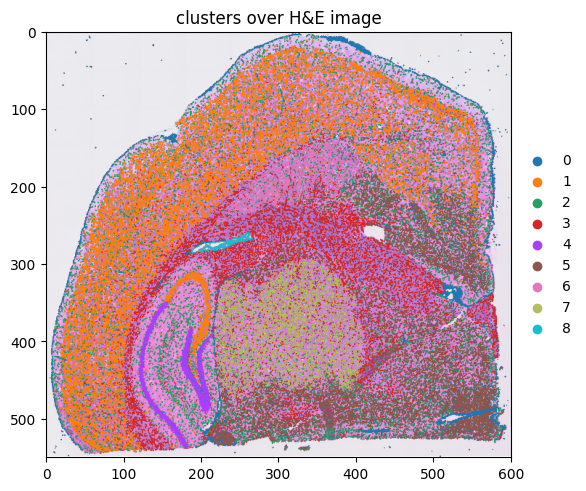

In [27]:
(
    visium_hd_mouse_brain.pl.render_images("Visium_HD_3prime_Mouse_Brain_lowres_image")
    .pl.render_shapes(
        "Visium_HD_3prime_Mouse_Brain_cell_segmentations", color="clusters", table_name="cell_segmentations"
    )
    .pl.show(title="clusters over H&E image", coordinate_systems="Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
)

In [28]:
def crop0_lowres(data, min_x, max_x, min_y, max_y, target_coordinate_system):
    return sd.bounding_box_query(
        data,
        min_coordinate=[min_x, min_y],
        max_coordinate=[max_x, max_y],
        axes=("x", "y"),
        target_coordinate_system=target_coordinate_system,
    )

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/query/relational_query.py:221: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  table = table.copy()
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/query/relational_query.py:78: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  table = table[table.obs[region_key].isin(element_names)].copy()
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1123: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


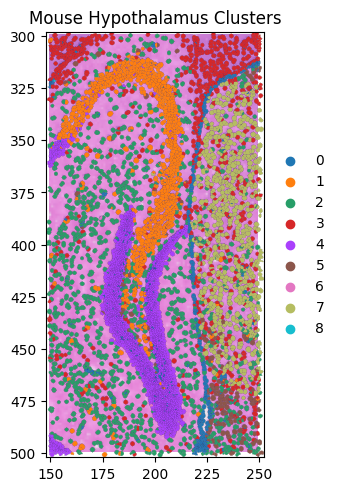

In [29]:
(
    crop0_lowres(visium_hd_mouse_brain, 150, 250, 300, 500, "Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
    .pl.render_images("Visium_HD_3prime_Mouse_Brain_lowres_image")
    .pl.render_shapes(
        "Visium_HD_3prime_Mouse_Brain_cell_segmentations", color="clusters", outline_width=0.10, outline_alpha=1
    )
    .pl.show(title="Mouse Hypothalamus Clusters", coordinate_systems="Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
)

# Calculate centroids

Use nucleus centroids for this calculation for use in analyses like cell cell communication


In [30]:
centroids = sd.get_centroids(
    visium_hd_mouse_brain.shapes["Visium_HD_3prime_Mouse_Brain_nucleus_segmentations"],
    coordinate_system="Visium_HD_3prime_Mouse_Brain_downscaled_lowres",
)
visium_hd_mouse_brain.points["Visium_HD_3prime_Mouse_Brain_nucleus_centroids"] = centroids
visium_hd_mouse_brain

/opt/miniconda3/envs/ome/lib/python3.13/functools.py:983: UserWarning: The index of the dataframe is not monotonic increasing. It is recommended to sort the data to adjust the order of the index before calling .parse() (or call `parse(sort=True)`) to avoid possible problems due to unknown divisions.
  return dispatch(args[0].__class__).__get__(obj, cls)(*args, **kwargs)


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/visium_hd_4.0.1_io/data.zarr
├── Images
│     ├── 'Visium_HD_3prime_Mouse_Brain_hires_image': DataArray[cyx] (3, 5492, 6000)
│     └── 'Visium_HD_3prime_Mouse_Brain_lowres_image': DataArray[cyx] (3, 549, 600)
├── Points
│     └── 'Visium_HD_3prime_Mouse_Brain_nucleus_centroids': DataFrame with shape: (<Delayed>, 2) (2D points)
├── Shapes
│     ├── 'Visium_HD_3prime_Mouse_Brain_cell_segmentations': GeoDataFrame shape: (84031, 2) (2D shapes)
│     └── 'Visium_HD_3prime_Mouse_Brain_nucleus_segmentations': GeoDataFrame shape: (83153, 2) (2D shapes)
└── Tables
      ├── 'cell_segmentations': AnnData (84031, 33696)
      └── 'nucleus_segmentations': AnnData (83153, 33696)
with coordinate systems:
    ▸ 'Visium_HD_3prime_Mouse_Brain', with elements:
        Visium_HD_3prime_Mouse_Brain_hires_image (Images), Visium_HD_3prime_Mouse_Brain_lowres_image (Images), Visium_HD_3prime_Mouse_Brain_cell

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/render.py:687: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  adata = AnnData(
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


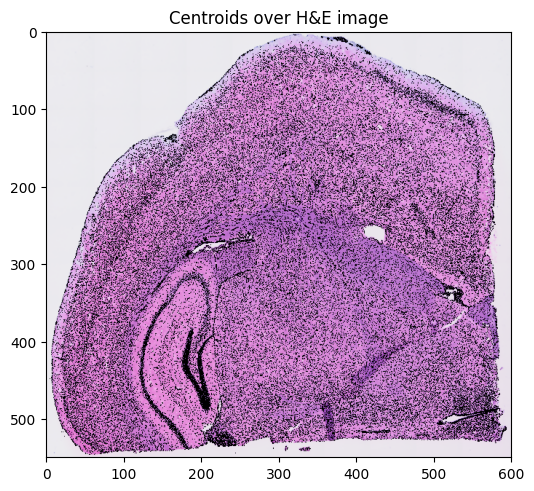

In [31]:
(
    visium_hd_mouse_brain.pl.render_images("Visium_HD_3prime_Mouse_Brain_lowres_image")
    .pl.render_points("Visium_HD_3prime_Mouse_Brain_nucleus_centroids", size=0.2, color="black")
    .pl.show(title="Centroids over H&E image", coordinate_systems="Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
)

/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/query/relational_query.py:221: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  table = table.copy()
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/render.py:687: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  adata = AnnData(
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/render.py:928: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(


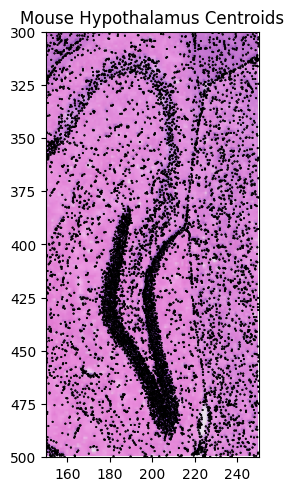

In [32]:
(
    crop0_lowres(visium_hd_mouse_brain, 150, 250, 300, 500, "Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
    .pl.render_images("Visium_HD_3prime_Mouse_Brain_lowres_image")
    .pl.render_points("Visium_HD_3prime_Mouse_Brain_nucleus_centroids", size=0.2, color="black")
    .pl.show(title="Mouse Hypothalamus Centroids", coordinate_systems="Visium_HD_3prime_Mouse_Brain_downscaled_lowres")
)